In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

all_files = glob.glob("../roll_data/*-fouls.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# select season (zero indexed)
season = 18
df = df[df["season"] == season]
print(len(df))
df.groupby("season").size()

78244


season
18    78244
dtype: int64

# Summary

The foul ball formula seems to be:
```python
foul_threshold = 0.25 + 0.1*fwd - 0.1*obt + (1/30)*(musc + thwack + div)
```
Rolls below this threshold are fouls, rolls above it are fair. Astrid figured this out last week, but I want to show it in a notebook to make it easier to find.
I have succeeded! It seems that this formula is correct.

Oddities in this formula:

- Traveling applies something like a 3.5% boost, not the 5% advertised
- Growth applies something like a 0-3.5% boost, not the 0-5% boost advertised
- Night Vision Goggles are real! Not applying that boost causes an outlier here. It's kind of annoying to apply though since it's not a modification, but instead a DE-era item.

Also, the attribute-specific boosts of Chunky and Smooth matter here, and it seems that they aren't necessarily a flat 100% to every affected attribute. Using 15% for the musclitude boost of Smooth made it work here. Worked out 15% via this:

Spin Attack ("+15% speed" blessing) results:
```
Hewitt Best:
musc:  0.7458 to 0.7683 : 0.0225
cont:  1.098  to 1.173  : 0.075
gf:    0.378  to 0.453  : 0.075
laser: 1.06   to 1.18   : 0.12
```

Ooze, in the same election, boosted "power" by "10%". according to Thomas Dracaena's history, it boosted:
```
div:  0.10
musc: 0.10
gf:   0.05
```
So div and musc would be actually +100% for Chunky, if this ratio holds (and indeed using that worked for me here).


## Helper function definitions

In [2]:
def is_max_blaseball(row):
    
    is_maximum_blaseball = (
            row["strike_count"] == 2
            and row["ball_count"] == 3
            and row["out_count"] == 2
            and row["baserunner_count"] == 3
        )
    return is_maximum_blaseball

def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
        # mul += 0.05
    if ("HIGH_PRESSURE" in ptm) or ("HIGH_PRESSURE" in pm):
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "MINIMALIST" in pm:
        if is_max_blaseball(row):
            mul -= 0.75
    if "MAXIMALIST" in pm:
        if is_max_blaseball(row):
            multiplier += 2.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    if ("LATE_TO_PARTY" in btm) and (row["day"] == 72) and ("OVERPERFORMING" not in btm):
        btm += ";OVERPERFORMING"
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if ("TRAVELING" in btm) or ("TRAVELING" in bm):
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.05
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if ("HIGH_PRESSURE" in btm) or ("HIGH_PRESSURE" in bm):
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # only doing 15% because of evidence from the Spin Attack blessing that "speed"
        # only boosts musc 15% of what it says the total boost is?
        mul += 0.15
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    if "MINIMALIST" in bm:
        if is_max_blaseball(row):
            mul -= 0.75
    if "MAXIMALIST" in bm:
        if is_max_blaseball(row):
            multiplier += 2.50
        
    return mul, attrs

## Apply multipliers to data

In [3]:
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

# had to do all this to make chunky and smooth work correctly
for attr in ["batter_musclitude", "batter_thwackability", "batter_divinity"]:
    df[attr+"_scaled"] = df.apply(lambda x: x[attr] * x["batter_mul"]
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr],
                                  axis=1)



df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

In [4]:
# df = df[(df["batting_team_hype"] == 0) & (df["pitching_team_hype"] == 0)]

df["musc_vibes"] = df["batter_musclitude_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["thwack_vibes"] = df["batter_thwackability_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["div_vibes"] = df["batter_divinity_scaled"] * (1 + 0.2 * df["batter_vibes"])

df["batter_attrs"] = (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3

df["batter_hype_vibes"] = df['batting_team_hype'] * (1 + 0.2 * df["batter_vibes"])
df["pitcher_hype_vibes"] = df['pitching_team_hype'] * (1 + 0.2 * df["batter_vibes"])

df["hypediff"] = (df['batting_team_hype'] - df['pitching_team_hype']) * (1 + 0.2 * df["batter_vibes"])
# put in our "best fit" up here in the original df, just because

df["threshold_best"] = (0.25
                        + 0.10 * df['ballpark_forwardness'] 
                        - 0.10 * df['ballpark_obtuseness'] 
                        + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                       )

## Exclude data
For instance, can exclude specific mods, or situations with multipliers != 1.0. Here, I'm going to be excluding batters with O No, because that creates tons of foul balls that "shouldn't be" foul balls.

I'm also excluding ON_FIRE (and maybe SPICY) batters because that mod is complicated and I don't want to deal with it right now

In [5]:
dfc = df.copy()
# dfc = dfc[~dfc["passed"].isna()]
# Sorry, Chorby Short
for exclude_mod in ["O_NO", "ON_FIRE", "SLOW_BUILD", "TRAVELING", "CHUNKY", "SMOOTH"]:
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]

# dfc = dfc.drop(labels=[148058, 155562, 95205, 95207], axis=0)
# dfc.loc[95200:95210,:]

In [6]:
# there are so many columns now, alas
# print(list(df.columns))
print(len(df))
print(len(dfc))
# dfc.head()

78244
65026


In [22]:
# preparing a useful digest list of columns for later
digest_list = [
    "event_type",
    "passed",
    "roll",
    "threshold",
    "offset",
    # "threshold_best",
    # "pitcher_name",
    "div_vibes",
    "musc_vibes",
    "thwack_vibes",
    "batter_vibes",
    "batter_mul",
    "ballpark_forwardness",
    "ballpark_obtuseness",
    "hypediff",
    # "pitcher_mul",
    "batter_name",
    "batter_mods",
    "batting_team_mods",
    # "pitcher_mods",
    # "pitching_team_mods",
    # "batting_team_hype",
    # "pitching_team_hype",
    "game_id",
    "play_count",
    "weather",
]


### Preliminary plot

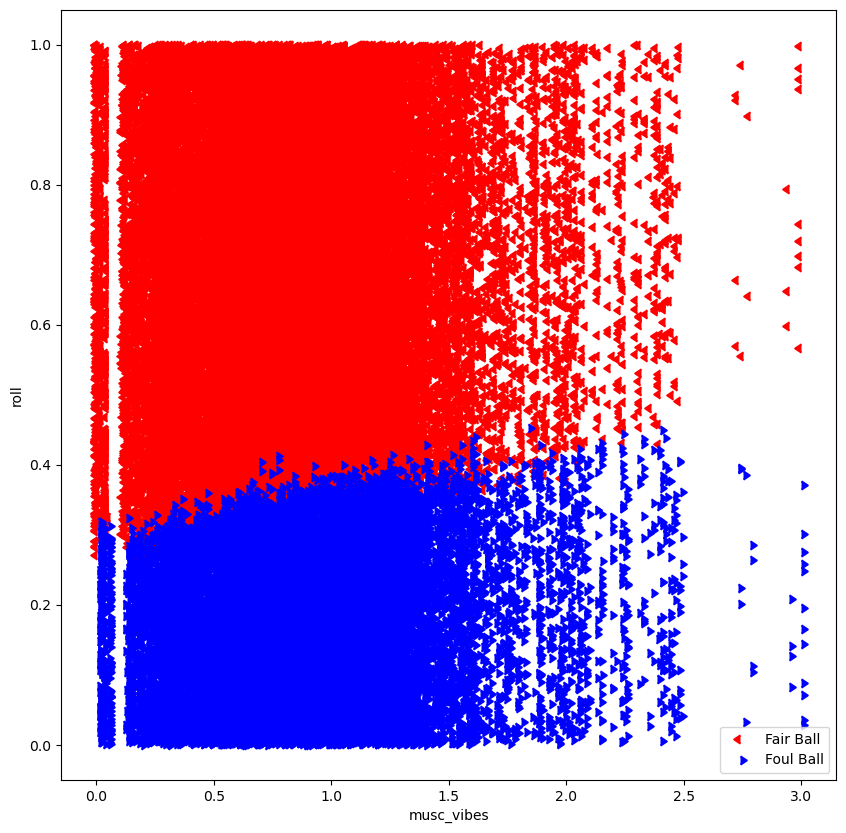

In [8]:
x_val = "musc_vibes"
# x_val = "threshold_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"].astype("bool")][x_val],
    dfc[~dfc["passed"].astype("bool")]["roll"],
    color="red",
    label="Fair Ball",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig("../figures/" + x_val + ".png", facecolor="white")

## SVC fit

In [9]:
# The "include "passed" in X and then drop it" stuff is useful if you need to exclude a range of rolls,
# say because there's a max value for the threshold (like in the strike zone formula).
X = dfc[["passed",
         "roll",
         # "div_vibes",
         # "musc_vibes",
         # "thwack_vibes",
         "batter_attrs",
         "ballpark_forwardness",
         "ballpark_obtuseness",
         # "batting_team_hype",
         # "pitching_team_hype",
         # "batter_hype_vibes",
         # "pitcher_hype_vibes",
         "hypediff",
        ]].copy()

# X = X[X["roll"] < 0.85]
y = X["passed"].astype("bool")
X = X.drop(["passed"], axis=1)
X.shape

(65026, 5)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm


sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[42731    11]
 [    7 22277]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     42742
        True       1.00      1.00      1.00     22284

    accuracy                           1.00     65026
   macro avg       1.00      1.00      1.00     65026
weighted avg       1.00      1.00      1.00     65026

0.9997231876480177


In [11]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.25025517]


[(1.0, 'roll'),
 (-0.10022719503797324, 'ballpark_forwardness'),
 (0.09971379758635758, 'ballpark_obtuseness'),
 (-0.09926675676525175, 'batter_attrs'),
 (-0.020072788351179198, 'hypediff')]

## Calculate threshold from fit

In [12]:
dfc['threshold'] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc['threshold'] += pair[0] * dfc[pair[1]]

# if you want to do a manual version instead, put it here

dfc["threshold"] = (0.250
                    + 0.10 * df['ballpark_forwardness']
                    - 0.10 * df['ballpark_obtuseness']
                    + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                    + 0.02 * df["hypediff"]
                    )

[0.25025517]
(0.09926675676525175, 'batter_attrs')
(0.10022719503797324, 'ballpark_forwardness')
(-0.09971379758635758, 'ballpark_obtuseness')
(0.020072788351179198, 'hypediff')


## Find Outliers

10


,event_type,passed,roll,threshold,offset,div_vibes,musc_vibes,thwack_vibes,batter_vibes,batter_mul,ballpark_forwardness,ballpark_obtuseness,hypediff,batter_name,batter_mods,batting_team_mods,game_id,play_count,weather,season
88726,Foul,True,0.302780,0.302229,0.000551,0.925722,0.753525,0.585960,-0.387178,0.81,0.415052,0.647833,0.000000,Lady Matsuyama,HOMEBODY;UNDERPERFORMING,SINKING_SHIP,a953275a-22d6-4b8d-b87d-82a02ad075a2,104,Weather.PEANUTS,18
139264,Fair,False,0.361263,0.361723,-0.000459,1.086566,0.762548,1.516784,-0.048523,1.20,0.574707,0.668573,0.445633,Frankie Hambone,<NA>,UNDERSEA;PARTY_TIME;LATE_TO_PARTY;LIFE_OF_PART...,33338c3d-1589-49e7-b745-a4cd970b35f3,42,Weather.FLOODING,18
62389,Fair,False,0.397383,0.397982,-0.000600,1.287767,1.519204,1.214878,-0.276080,1.20,0.575417,0.436212,0.000000,Kaz Fiasco,<NA>,LATE_TO_PARTY;OVERPERFORMING;LIFE_OF_PARTY;BAS...,c58496ff-2173-40ca-9270-93efa47ab230,41,Weather.FLOODING,18
69939,Fair,False,0.322412,0.323040,-0.000627,1.066575,0.748519,1.488878,-0.139620,1.20,0.491396,0.745675,-0.583246,Frankie Hambone,<NA>,LATE_TO_PARTY;OVERPERFORMING;LIFE_OF_PARTY;UND...,4b0e0e47-be71-487f-b698-e1b8689121ae,176,Weather.BLACK_HOLE,18
58263,Fair,False,0.387938,0.388660,-0.000722,1.597608,1.079655,1.579806,0.329757,1.40,0.518072,0.588866,0.191871,Aldon Cashmoney II,MIDDLING;CAREFUL;OVERPERFORMING;REPLICA;SPICY;...,FIREPROOF;SEALANT;AMBUSH;LATE_TO_PARTY;FIERY,a8a94214-f21f-4199-84da-aa4927eacdaa,26,Weather.FLOODING,18
68445,Fair,False,0.342908,0.343842,-0.000934,1.378619,1.311067,1.336885,0.932153,1.20,0.491396,0.745675,-0.747451,Ortiz Lopez,FIRE_EATER,LATE_TO_PARTY;OVERPERFORMING;LIFE_OF_PARTY;UND...,5f4d8938-44c0-4cc1-91db-5b13cd72a340,15,Weather.FLOODING,18
7036,Fair,False,0.383747,0.385206,-0.001459,1.382869,1.125636,0.875322,-0.387178,1.21,0.560639,0.336525,0.000000,Lady Matsuyama,OVERPERFORMING;HOMEBODY,SINKING_SHIP,fc77a95b-9530-400b-8c35-6fe67ab68ed5,293,Weather.FEEDBACK,18
139403,Fair,False,0.383231,0.384715,-0.001485,1.439494,1.588365,1.006233,0.351158,1.20,0.574707,0.668573,0.481604,Flattery McKinley,ALTERNATE,UNDERSEA;PARTY_TIME;LATE_TO_PARTY;LIFE_OF_PART...,33338c3d-1589-49e7-b745-a4cd970b35f3,85,Weather.FLOODING,18
141280,Fair,False,0.368299,0.370531,-0.002232,0.522055,1.499782,1.405180,0.474163,1.20,0.485629,0.356969,-0.328450,Usurper Violet,COFFEE_RALLY;SOUNDPROOF,PARTY_TIME;LATE_TO_PARTY;AA;OVERPERFORMING;AFF...,280015db-7dd8-4d96-85b1-8bedc2f950e3,54,Weather.COFFEE_2,18
82846,Fair,False,0.393041,0.398996,-0.005955,0.593109,1.703910,1.596432,-0.024620,1.50,0.563717,0.473072,0.507489,Usurper Violet,SOUNDPROOF,AFFINITY_FOR_CROWS;AA,b2d45639-ce9b-4a74-baee-5a033129f0ec,182,Weather.BIRDS,18


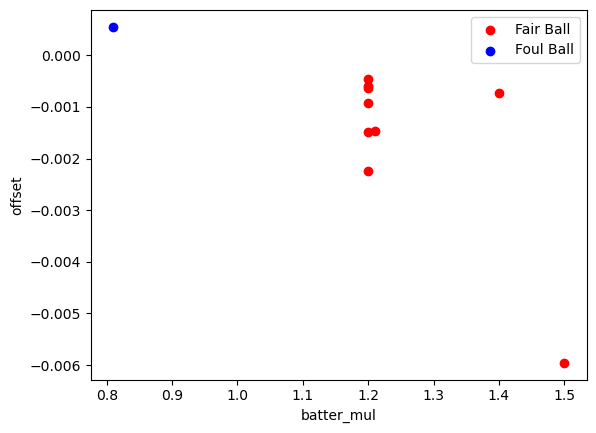

In [23]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
# outliers = outliers[outliers["season"] < 18]
fig, ax = plt.subplots(1)
x_val = "threshold"
x_val = "batter_mul"
ax.scatter(
    outliers[~(outliers["passed"].astype("bool"))][x_val],
    outliers[~(outliers["passed"].astype("bool"))]["offset"],
    color="red",
    label="Fair Ball",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Foul Ball",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(outliers))
table[[*digest_list, "season"]].sort_values("offset", ascending=False)

In [14]:
testgame = 'c9c59adb-4f45-4c89-9d75-f19d95701e7e'
# testdf = dfc[(dfc['game_id'] == testgame) & (dfc['batter_name'] == "Conner Haley")]
testdf = dfc[(dfc['batter_name'] == "Sandie Turner")]

In [15]:
# testdf.loc[:, digest_list].sort_values("batter_consecutive_hits", ascending=False)[0:10]

In [16]:
print(coef_scaled[0, :], intercept_scaled)

[ 1.         -0.09926676 -0.1002272   0.0997138  -0.02007279] [-0.25025517]


## Visualize Threshold

Text(0.5, 0.98, 'All Seasons')

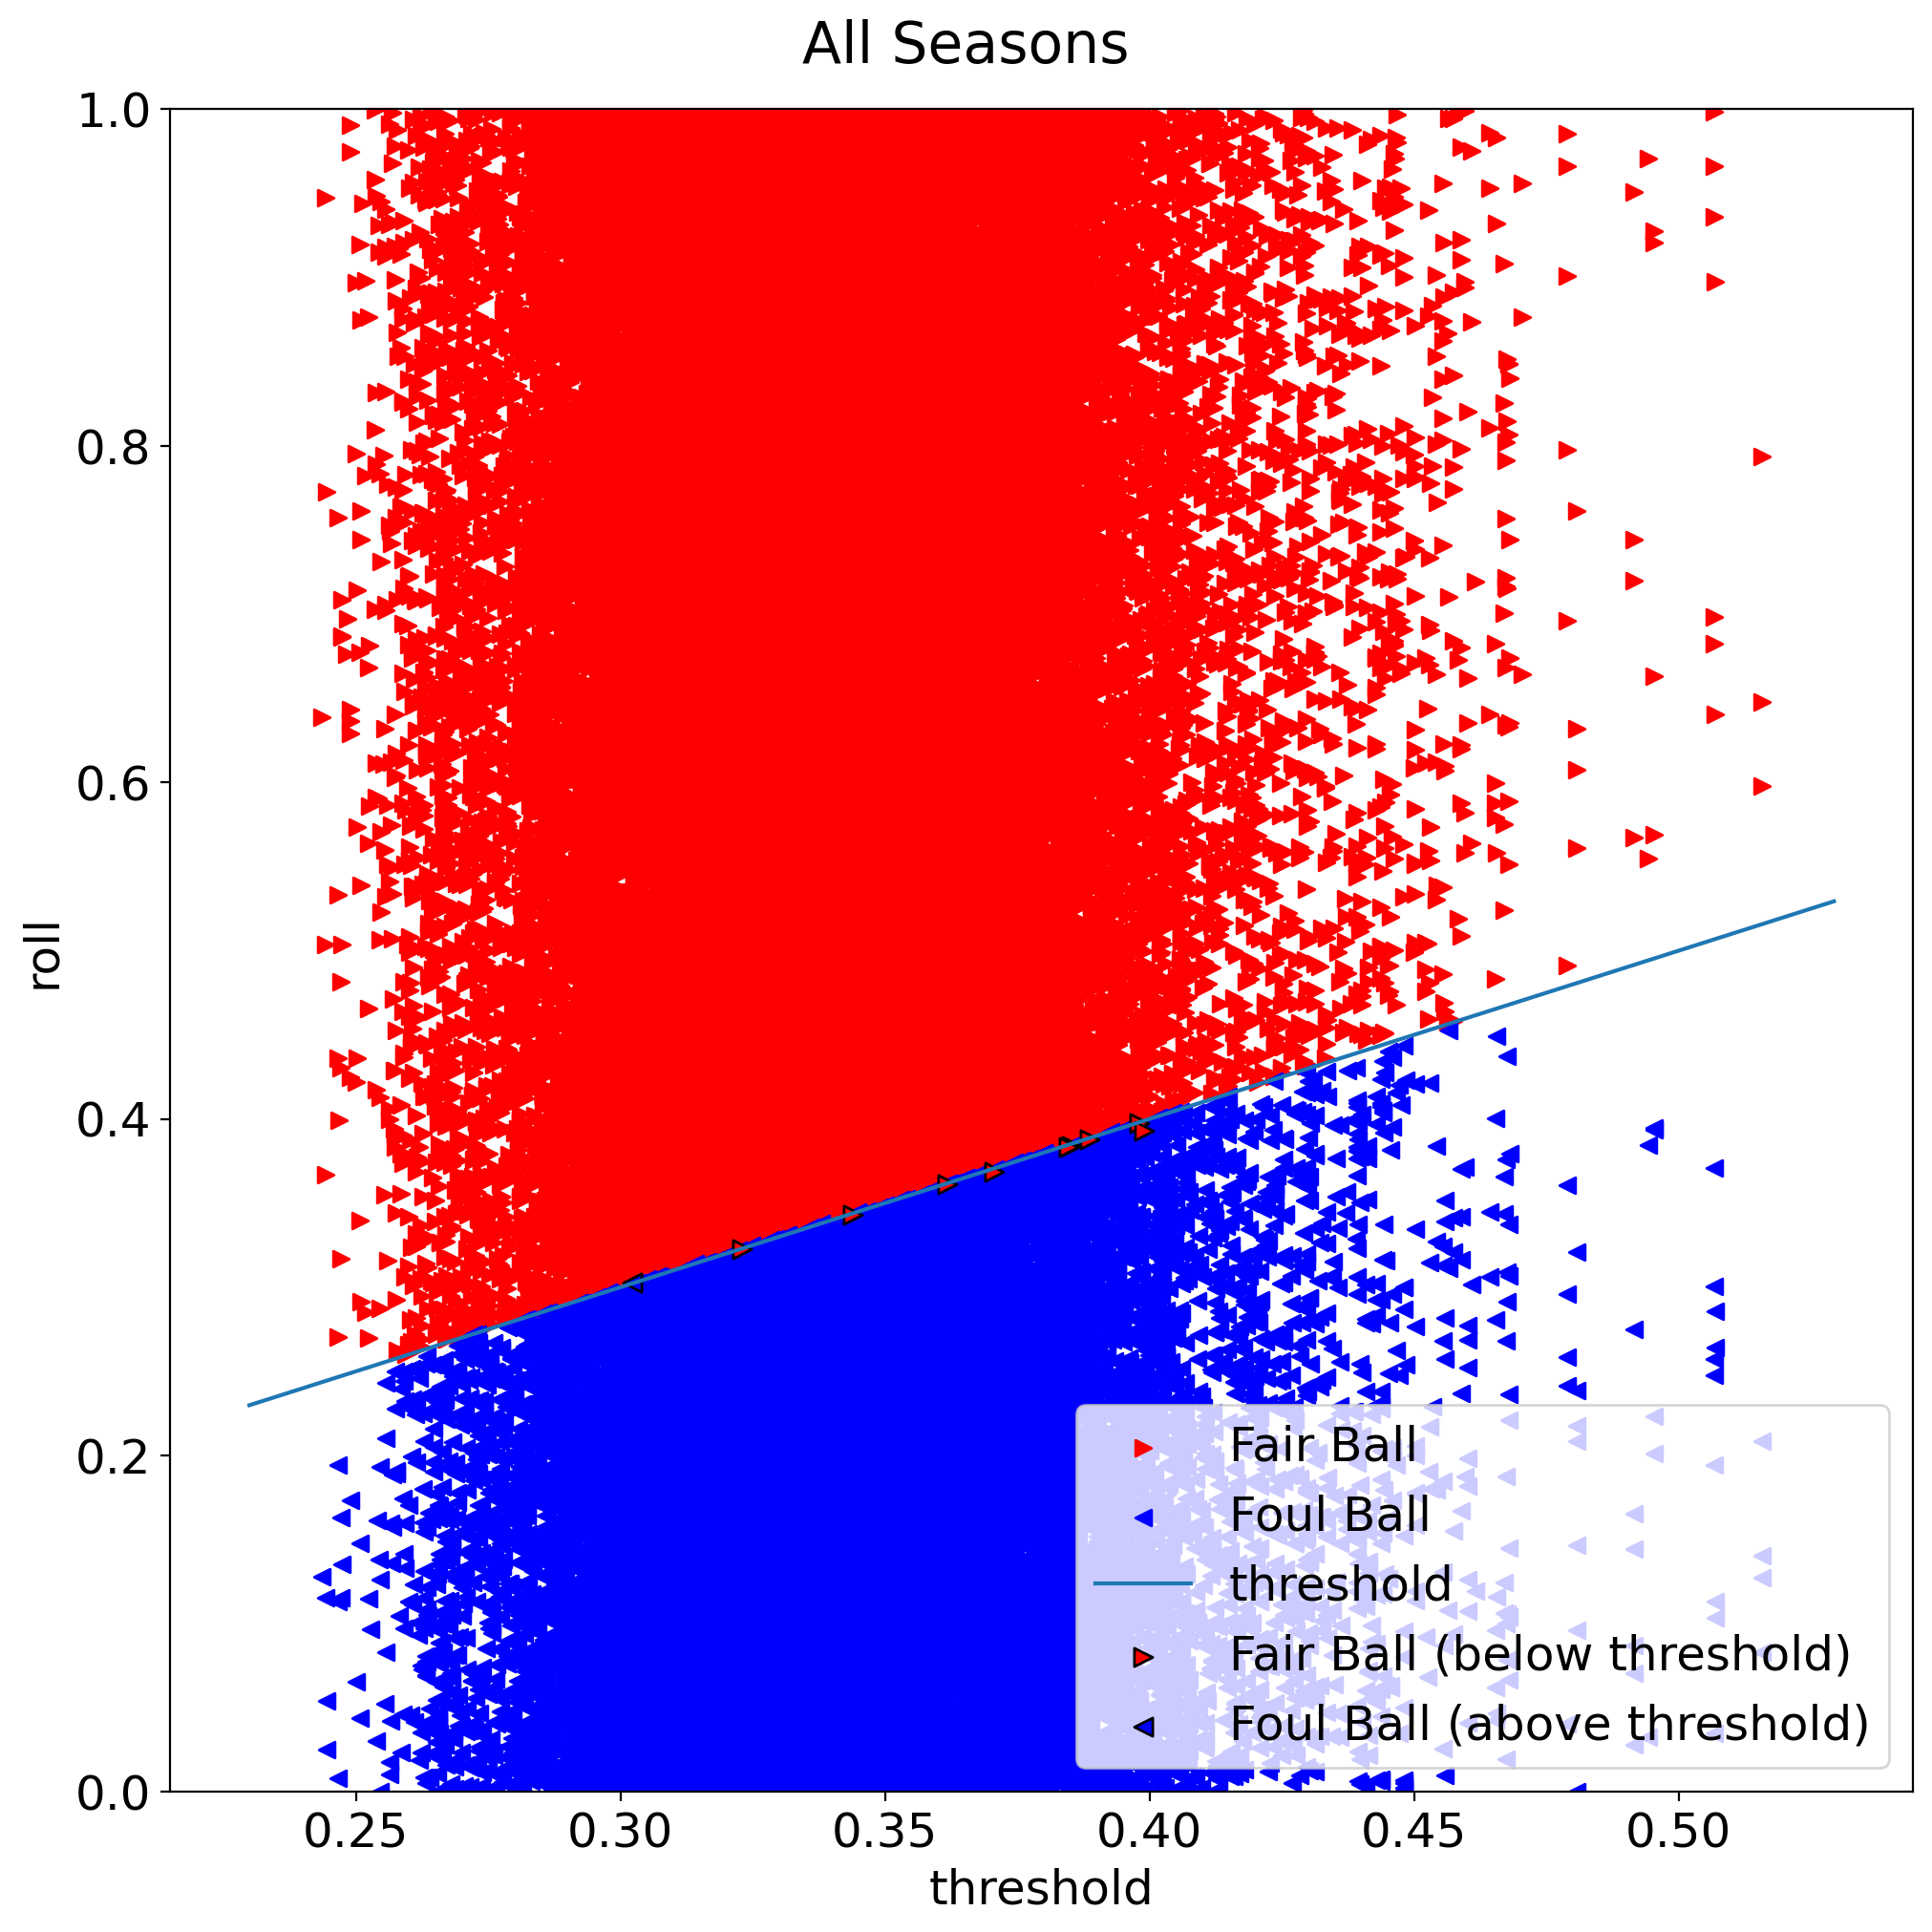

In [17]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

ax.set_ylim(0, 1)
ax.scatter(
    dfc[~(dfc["passed"].astype(bool))][x_val],
    dfc[~(dfc["passed"].astype(bool))]["roll"],
    color="red",
    label="Fair Ball",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker="<",
)
xline = ax.get_xlim()
yline = xline
ax.plot(xline, yline, label="threshold")
if len(outliers) > 0:
    ax.scatter(outliers[~(outliers['passed'].astype(bool))][x_val], outliers[~(outliers['passed'].astype(bool))]["roll"],
               s=48, edgecolor='black', color="red", label="Fair Ball (below threshold)", marker='>')
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
               s=48, edgecolor='black', color="blue", label="Foul Ball (above threshold)", marker='<')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_ylim(0.85, 0.86)

ax.legend(loc="lower right")
# fig.suptitle(f"Season {season+1}")
fig.suptitle(f"All Seasons")
# fig.savefig("../figures/strikes_s14_flinch.png", facecolor='white', dpi=200)
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

In [18]:
outliers.groupby("season").size()

season
18    10
dtype: int64

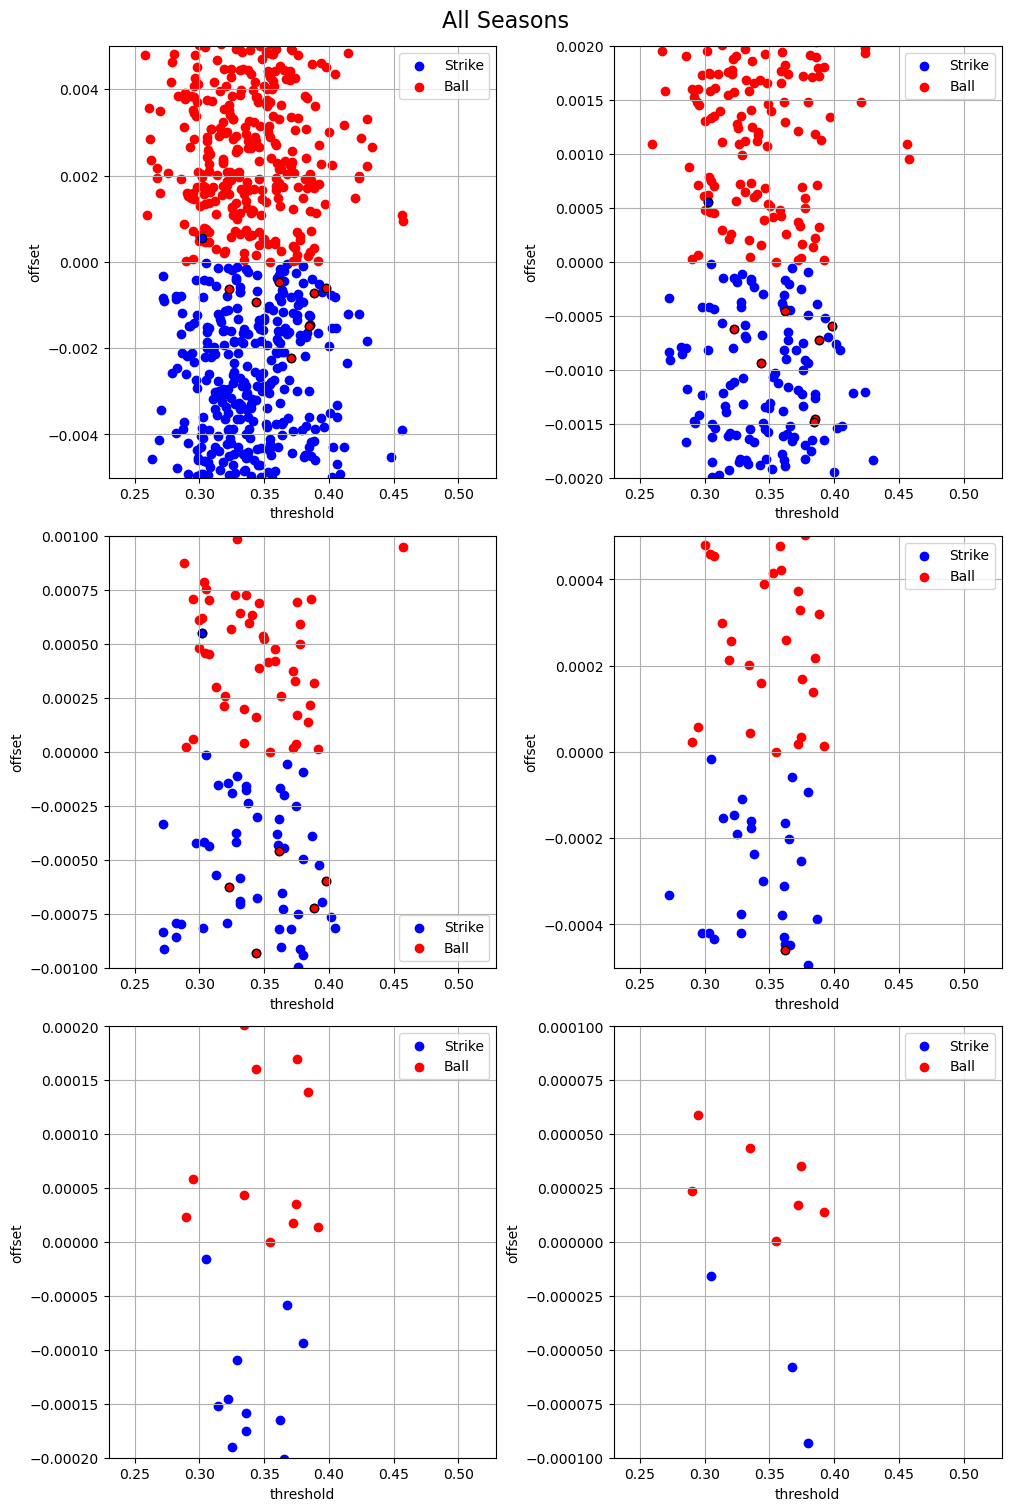

In [19]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1}", fontsize=16)
fig.suptitle(f"All Seasons", fontsize=16)
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~(dfc["passed"].astype(bool))][x_val],
        dfc[~(dfc["passed"].astype(bool))]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~(outliers["passed"].astype(bool))][x_val],
        outliers[~(outliers["passed"].astype(bool))]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/ball_strike_fit_offsets.png", facecolor='white')